In [1]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_theme()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
from collections import Counter

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from scipy.stats import norm
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from neuralsens import partial_derivatives as ns

#Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.vq import vq
import skfuzzy as fuzz
from skfuzzy import cmeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances
from itertools import combinations
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture

#Profiling
import line_profiler
from line_profiler import LineProfiler
%load_ext line_profiler

from funciones_limpieza import *
from funciones_clustering import *
from utils_aprendizaje_no_supervisado import * 


# Preprocesado y cálculo PCA datos parque Myrtle

In [2]:
carpeta = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/Datos Parque MYRTLE/Plots Myrtle'
pca, X_pca = preprocesado_y_pca(carpeta, 10)

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")
/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match len

In [3]:
#Nos quedamos con las tres primeras componentes principales pues vimos que eran las más representativas
X_pca_3 = X_pca[:, :3]
X_pca_3.size

9071790

# Gaussian Mixture Models

In [4]:
#DOCUMENTACIÓN GAUSSIANMIXTURE() SCIKIT-LEARN 
#---------------------------------------------

#Parameters:

#n_components int, default=1: The number of mixture components.

#covariance_type{‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’: String describing the type of covariance parameters to use. Must be 
#one of:
# - ‘full’: each component has its own general covariance matrix.
# - ‘tied’: all components share the same general covariance matrix.
# - ‘diag’: each component has its own diagonal covariance matrix.
# - ‘spherical’: each component has its own single variance.

#tol float, default=1e-3: The convergence threshold. EM iterations will stop when the lower bound average gain is below this threshold.

#reg_covar float, default=1e-6: Non-negative regularization added to the diagonal of covariance. Allows to assure that the covariance matrices are all positive.

#max_iter int, default=100: The number of EM iterations to perform.

#n_init int, default=1: The number of initializations to perform. The best results are kept.

#init_params{‘kmeans’, ‘k-means++’, ‘random’, ‘random_from_data’}, default=’kmeans’: The method used to initialize the weights, the means 
#and the precisions. String must be one of:
# - ‘kmeans’ : responsibilities are initialized using kmeans.
# - ‘k-means++’ : use the k-means++ method to initialize.
# - ‘random’ : responsibilities are initialized randomly.
# - ‘random_from_data’ : initial means are randomly selected data points.

#weights_init array-like of shape (n_components, ), default=None: The user-provided initial weights. If it is None, weights are initialized 
#using the init_params method.

#means_init array-like of shape (n_components, n_features), default=None: The user-provided initial means, If it is None, means are 
#initialized using the init_params method.

#precisions_init array-like, default=None: The user-provided initial precisions (inverse of the covariance matrices). If it is None, 
#precisions are initialized using the ‘init_params’ method. The shape depends on ‘covariance_type’:
# - (n_components,)                        if 'spherical',
# - (n_features, n_features)               if 'tied',
# - (n_components, n_features)             if 'diag',
# - (n_components, n_features, n_features) if 'full'

#random_state int, RandomState instance or None, default=None: Controls the random seed given to the method chosen to initialize the 
#parameters (see init_params). In addition, it controls the generation of random samples from the fitted distribution (see the method sample). Pass an int for reproducible output across multiple function calls. See Glossary.

#warm_start bool, default=False: If ‘warm_start’ is True, the solution of the last fitting is used as initialization for the next call of 
#fit(). This can speed up convergence when fit is called several times on similar problems. In that case, ‘n_init’ is ignored and only a 
#single initialization occurs upon the first call. See the Glossary.

#verbose int, default=0: Enable verbose output. If 1 then it prints the current initialization and each iteration step. If greater than 1 
#then it prints also the log probability and the time needed for each step.

#verbose_interval int, default=10: Number of iteration done before the next print.

#### ELECCIÓN MATRIZ DE COVARIANZA

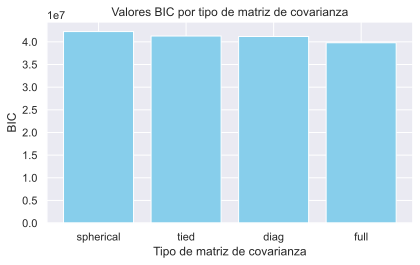

In [6]:
# Tunning del modelo GMM --> https://cienciadedatos.net/documentos/py23-deteccion-anomalias-gmm-python
# -----------------------------------------------------------------------------------------------------

#Vamos a ver que tipo de matriz de covarianza se ajusta mejor a nuestros datos 
covariance_types = ['spherical', 'tied', 'diag', 'full']

bic_values = []

# Calcular BIC para cada tipo de covarianza
for covariance_type in covariance_types:
    GMM = GaussianMixture(n_components=2, covariance_type=covariance_type, random_state=10)
    GMM.fit(X_pca_3)
    bic = GMM.bic(X_pca_3)
    bic_values.append(bic)

fig, ax = plt.subplots(figsize=(6, 3.84))
ax.bar(covariance_types, bic_values, color='skyblue')
ax.set_title("Valores BIC por tipo de matriz de covarianza")
ax.set_xlabel("Tipo de matriz de covarianza")
ax.set_ylabel("BIC")

plt.tight_layout()
plt.savefig('./Imagenes/GMM/eleccion_tipo_centro')
plt.show()

#Observamos que el tipo 'full' es el que menor valor BIC tiene por lo que usaremos este. Esto nos indica que nuestros clusters nno tendrán una
#forma esférica perfecta y el clusterin de GMM dejará que los clusters tengan formas más libres

#### ENTRENO GMM CON 2 CLUSTERS

In [4]:
# Fit final model 
#-----------------
clusterer_GMM = GaussianMixture(n_components=2,
                                covariance_type='full',
                                random_state=10)

# Predict on training dataset
cluster_GMM = clusterer_GMM.fit_predict(X_pca_3)

In [5]:
print('Clusters specifying number of clusters:')
unique, counts = np.unique(cluster_GMM, return_counts=True)

# Calcular el porcentaje de elementos en cada cluster
total_samples = len(cluster_GMM)
percentages = (counts / total_samples) * 100

# Crear un DataFrame para visualizar el número de elementos y los porcentajes
df_clusters = pd.DataFrame({
    '# Samples': counts,
    'Percentage (%)': percentages
}, index=unique)

# Mostrar el DataFrame con los resultados
print(df_clusters)

Clusters specifying number of clusters:
   # Samples  Percentage (%)
0    1024928       33.893906
1    1999002       66.106094


#### VISUALIZACIÓN CLUSTERS

In [18]:
# Obtener etiquetas predichas por GMM
cluster_labels = clusterer_GMM.predict(X_pca_3)

# Obtener los centros de los clusters (medias de las Gaussianas)
cluster_centers = clusterer_GMM.means_

# Muestrear un pequeño porcentaje de los datos para visualizar
sample_size = int(X_pca_3.shape[0] * 1)  # 100% en este caso, puedes ajustar
sampled_indices = np.random.choice(X_pca_3.shape[0], sample_size, replace=False)
sampled_X = X_pca_3[sampled_indices, :]
sampled_labels = cluster_labels[sampled_indices]

# Número de componentes principales
n_components = X_pca_3.shape[1]
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, len(pairs) * 6))
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Creamos un scatter plot para cada cluster individual para poder añadir la leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )
    
    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])

    ax.set_title(f"GMM: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/clusters_gmm_k2_PCA3.png')
plt.close()

In [ ]:
import numpy as np

# Contar cuántos puntos hay en cada cluster
unique, counts = np.unique(cluster_labels, return_counts=True)

# Calcular porcentaje para cada cluster
percentages = 100 * counts / len(cluster_labels)

# Mostrar resultados
for cluster_id, count, perc in zip(unique, counts, percentages):
    print(f"Cluster {cluster_id}: {count} puntos, {perc:.2f}% del total")


#### VALOR MEDIO PCA DE LOS CENTROIDES

In [20]:
# Saber el valor medio que tienen los centroides de un cluster nos dará una idea intuitiva de los valores que toman para cada PCA los 
# puntos de un cluster

# Print values of the cluster centers
n_clusters = 2
print(cluster_centers) #los centroides están en el espacio de PCA

# Plot the values of the cluster center
for i in range(cluster_centers.shape[1]):
    plt.figure(figsize=(5, 3))
    sns.barplot(x=range(n_clusters), y=cluster_centers[:,i], edgecolor='black', palette='viridis')
    plt.xticks(range(n_clusters))
    plt.xlabel('Cluster')
    plt.ylabel('PC{}'.format(i+1))
    plt.title('Cluster centers for PC{}'.format(i+1))

    # Guardar la imagen en lugar de mostrarla
    # Aquí puedes cambiar la ruta y el nombre del archivo según lo desees
    nombre_archivo = f'/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/GMM2_cluster_centers_PC{i+1}.png'  # Nombre del archivo de la imagen
    plt.savefig(nombre_archivo, dpi=300)  # Guarda la imagen con alta resolución
    plt.close()  # Cierra la figura después de guardarla para evitar que se acumulen múltiples gráficos


[[ 6.11919003 -0.62579216  0.24564959]
 [-3.16128835  0.32329597 -0.12690719]]


/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_3842/2641464906.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(n_clusters), y=cluster_centers[:,i], edgecolor='black', palette='viridis')
/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_3842/2641464906.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=range(n_clusters), y=cluster_centers[:,i], edgecolor='black', palette='viridis')
/var/folders/wn/gxtmyy811gg8d_h61xk9hfkm0000gn/T/ipykernel_3842/2641464906.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barpl

#### PREDICCIÓN LOG PROBABILIDAD

In [10]:
log_probabilidad_predicha = clusterer_GMM.score_samples(X=X_pca_3) #Compute the log-likelihood of each sample.
log_probabilidad_predicha

array([-11.56183157, -11.57668831, -11.58033786, ...,  -7.32822521,
        -7.44108859,  -7.3422891 ])

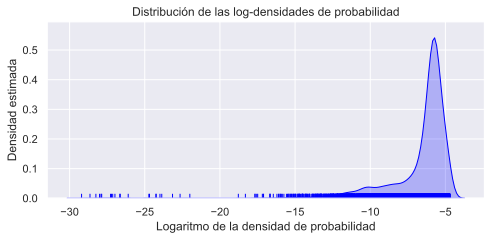

In [13]:
# Gráfico de la distribución de las log-densidades de probabilidad

# Reducir la cantidad de puntos (si no da error por excesiva cantidad de muestras)
if len(log_probabilidad_predicha) > 10000:
    log_prob_sample = np.random.choice(log_probabilidad_predicha, size=10000, replace=False)
else:
    log_prob_sample = log_probabilidad_predicha

fig, ax = plt.subplots(figsize=(7, 3.5))

sns.kdeplot(
    log_prob_sample,
    fill=True,         # Rellena el área bajo la curva (equivalente a 'shade=True')
    color='blue',
    linewidth=1,
    ax=ax
)

# Rugplot para mostrar la ubicación de los puntos individuales
sns.rugplot(
    log_prob_sample,
    color='blue',
    ax=ax
)

ax.set_title('Distribución de las log-densidades de probabilidad')
ax.set_xlabel('Logaritmo de la densidad de probabilidad')
ax.set_ylabel('Densidad estimada')
plt.tight_layout()

# Guardar imagen 
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/DistribucionLogDensidades_k2_PCA3.png')

plt.show()
#Cuanto mayor sea el logaritmo de densidad de probabilidad para un punto, más probable es que el modelo espere ese dato (normalmente, puntos próximos
#a los centroides tienen mayor densidad de probabilidad). ASí que una gran cantidad de nuestros puntos tenga densidad elevada indica que este modelo
#de clustering se ajusta bien los datos. Además que la zona de elevada dens¡dad no sea muy ancha indica que los datos están bienagrupados en torno
#a los centros de los clusters por lo que GMM ha dado con clusters compactos. 


### Ahora probamos este clustering con los datos de inversores con un funcionamiento a priori normal y uno con comportamiento anómalo

In [ ]:
#Vamos a considerar el inversor 34 y el 11 del día 13-02-25. Sabemos que el inversor 11 tuvo fallo de explosión tras congelar

#### INVERSOR 11

In [6]:
#LECTURA Y PPREPROCESADO INVERSOR 11
#-----------------------------------

carpeta_explosion_congelar = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/FalloExplosionTrasCongelarPruebas 13_02_25/inv11'
X_pca_explosion_congelar = aplicar_pca_datos(carpeta_explosion_congelar, pca)
# Seleccionar las primeras 3 componentes principales
X_pca_3_explosion_congelar = X_pca_explosion_congelar[:, :3]
X_pca_3_explosion_congelar.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


129573

In [13]:
# Aplicar el modelo GMM para predecir los clusters de los nuevos datos
clusters_predichos_explosion_congelar = clusterer_GMM.predict(X_pca_3_explosion_congelar)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_explosion_congelar)

# Mostrar el número de elementos en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")

#Tenemos más del doble de elementos en el cluster 1 que en el 0 (podemos ver con la siguiente gráfica que el cluster 1 de GMM se correspondería
#con el 0 de Kmeans)

Cluster 0: 13488 elementos (31.22%)
Cluster 1: 29703 elementos (68.76%)


In [8]:
#Visualizamos la distribución en clusters de estos puntos

# Obtener etiquetas predichas por GMM
cluster_labels = clusterer_GMM.predict(X_pca_3_explosion_congelar)

# Obtener los centros de los clusters (medias de las Gaussianas)
cluster_centers = clusterer_GMM.means_

# Muestrear un pequeño porcentaje de los datos para visualizar
sample_size = int(X_pca_3_explosion_congelar.shape[0] * 1)  # 100% en este caso, puedes ajustar
sampled_indices = np.random.choice(X_pca_3_explosion_congelar.shape[0], sample_size, replace=False)
sampled_X = X_pca_3_explosion_congelar[sampled_indices, :]
sampled_labels = cluster_labels[sampled_indices]

# Número de componentes principales
n_components = X_pca_3_explosion_congelar.shape[1]
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, len(pairs) * 6))
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Creamos un scatter plot para cada cluster individual para poder añadir la leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )
    
    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])

    ax.set_title(f"GMM: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/DistribucionClusters_GMM2_inv11Dia130225.png')
plt.close()



#### INVERSOR 34

In [9]:
#LECTURA Y PPREPROCESADO INVERSOR 34
#-----------------------------------

carpeta_inv34_130225 = '/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Datos_TFMGamesa/FalloExplosionTrasCongelarPruebas 13_02_25/inv34'  
X_pca_inv34_130225 = aplicar_pca_datos(carpeta_inv34_130225, pca)
# Seleccionar las primeras 3 componentes principales
X_pca_3_inv34_130225 = X_pca_inv34_130225[:, :3]
X_pca_3_inv34_130225.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


129597

In [12]:
# Aplicar el modelo GMM para predecir los clusters de los nuevos datos
clusters_predichos_inv34_130225 = clusterer_GMM.predict(X_pca_3_inv34_130225)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_inv34_130225)

# Total de elementos
total_elements = len(clusters_predichos_inv34_130225)

# Mostrar el número de elementos y el porcentaje en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")


#Tenemos más del doble de elementos en el cluster 1 que en el 0 (podemos ver con la siguiente gráfica que el cluster 1 de GMM se correspondería
#con el 0 de Kmeans)

Cluster 0: 14474 elementos (33.51%)
Cluster 1: 28725 elementos (66.49%)


In [14]:
#Visualizamos la distribución en clusters de estos puntos

# Obtener etiquetas predichas por GMM
cluster_labels = clusterer_GMM.predict(X_pca_3_inv34_130225)

# Obtener los centros de los clusters (medias de las Gaussianas)
cluster_centers = clusterer_GMM.means_

# Muestrear un pequeño porcentaje de los datos para visualizar
sample_size = int(X_pca_3_inv34_130225.shape[0] * 1)  # 100% en este caso, puedes ajustar
sampled_indices = np.random.choice(X_pca_3_inv34_130225.shape[0], sample_size, replace=False)
sampled_X = X_pca_3_inv34_130225[sampled_indices, :]
sampled_labels = cluster_labels[sampled_indices]

# Número de componentes principales
n_components = X_pca_3_inv34_130225.shape[1]
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, len(pairs) * 6))
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Creamos un scatter plot para cada cluster individual para poder añadir la leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )
    
    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])

    ax.set_title(f"GMM: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/DistribucionClusters_GMM2_inv34Dia130225.png')
plt.close()



### Ahora probamos con un inversor sin condensación (por ejemplo el 72) y otro que si (el 56)

#### Inversor 72 y 45

In [6]:
#LECTURA Y PPREPROCESADO INVERSOR SIN CONDENSACIÓN
#-------------------------------------------------

carpeta_sinCondensacion = "./InversorSinCondensacion"
X_pca_sinCondensacion = aplicar_pca_datos(carpeta_sinCondensacion, pca)
# Seleccionar las primeras 3 componentes principales
X_pca_3_sinCondensacion = X_pca_sinCondensacion[:, :3]
X_pca_3_sinCondensacion.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


129597

In [7]:
# Aplicar el modelo GMM para predecir los clusters de los nuevos datos
clusters_predichos_sinCondensacion = clusterer_GMM.predict(X_pca_3_sinCondensacion)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_sinCondensacion)

# Total de elementos
total_elements = len(clusters_predichos_sinCondensacion)

# Mostrar el número de elementos y el porcentaje en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")


#Tenemos más del doble de elementos en el cluster 1 que en el 0 (podemos ver con la siguiente gráfica que el cluster 1 de GMM se correspondería
#con el 0 de Kmeans)

Cluster 0: 15431 elementos (35.72%)
Cluster 1: 27768 elementos (64.28%)


In [10]:
#Visualizamos la distribución en clusters de estos puntos

# Obtener etiquetas predichas por GMM
cluster_labels = clusterer_GMM.predict(X_pca_3_sinCondensacion)

# Obtener los centros de los clusters (medias de las Gaussianas)
cluster_centers = clusterer_GMM.means_

# Muestrear un pequeño porcentaje de los datos para visualizar
sample_size = int(X_pca_3_sinCondensacion.shape[0] * 1)  # 100% en este caso, puedes ajustar
sampled_indices = np.random.choice(X_pca_3_sinCondensacion.shape[0], sample_size, replace=False)
sampled_X = X_pca_3_sinCondensacion[sampled_indices, :]
sampled_labels = cluster_labels[sampled_indices]

# Número de componentes principales
n_components = X_pca_3_sinCondensacion.shape[1]
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, len(pairs) * 6))
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Creamos un scatter plot para cada cluster individual para poder añadir la leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )
    
    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])

    ax.set_title(f"GMM: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/DistribucionClusters_GMM2_sinCondensacion.png')
plt.close()



#### Inversor 56

In [8]:
#LECTURA Y PPREPROCESADO INVERSOR CON CONDENSACIÓN
#-------------------------------------------------

carpeta_condensacion = "./InversorCondensacion"
X_pca_condensacion = aplicar_pca_datos(carpeta_condensacion, pca)
# Seleccionar las primeras 3 componentes principales
X_pca_3_condensacion = X_pca_condensacion[:, :3]
X_pca_3_condensacion.size

/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/funciones_limpieza.py:124: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  plots = pd.read_csv(nombre_csv, index_col = False, sep = ";")


129597

In [9]:
# Aplicar el modelo GMM para predecir los clusters de los nuevos datos
clusters_predichos_condensacion = clusterer_GMM.predict(X_pca_3_condensacion)  # Usamos los datos ya transformados

# Número de elementos en cada cluster
cluster_counts = np.bincount(clusters_predichos_condensacion)

# Total de elementos
total_elements = len(clusters_predichos_condensacion)

# Mostrar el número de elementos y el porcentaje en cada clúster
for cluster_id, count in enumerate(cluster_counts):
    percentage = (count / total_elements) * 100
    print(f"Cluster {cluster_id}: {count} elementos ({percentage:.2f}%)")

Cluster 0: 17108 elementos (39.60%)
Cluster 1: 26091 elementos (60.40%)


In [11]:
#Visualizamos la distribución en clusters de estos puntos

# Obtener etiquetas predichas por GMM
cluster_labels = clusterer_GMM.predict(X_pca_3_condensacion)

# Obtener los centros de los clusters (medias de las Gaussianas)
cluster_centers = clusterer_GMM.means_

# Muestrear un pequeño porcentaje de los datos para visualizar
sample_size = int(X_pca_3_condensacion.shape[0] * 1)  # 100% en este caso, puedes ajustar
sampled_indices = np.random.choice(X_pca_3_condensacion.shape[0], sample_size, replace=False)
sampled_X = X_pca_3_condensacion[sampled_indices, :]
sampled_labels = cluster_labels[sampled_indices]

# Número de componentes principales
n_components = X_pca_3_condensacion.shape[1]
pairs = list(combinations(range(n_components), 2))

# Crear los subgráficos
fig, axes = plt.subplots(len(pairs), 1, figsize=(10, len(pairs) * 6))
if len(pairs) == 1:
    axes = [axes]

# Visualización por pares de componentes principales
for idx, (i, j) in enumerate(pairs):
    ax = axes[idx]

    # Creamos un scatter plot para cada cluster individual para poder añadir la leyenda
    for cluster_id in np.unique(sampled_labels):
        cluster_points = sampled_X[sampled_labels == cluster_id]
        ax.scatter(
            cluster_points[:, i], cluster_points[:, j],
            label=f"Cluster {cluster_id}",
            alpha=0.5,
            s=10
        )
    
    # Visualización de los centros
    ax.scatter(
        cluster_centers[:, i], cluster_centers[:, j],
        c='red', marker='X', s=80, label="Centroides"
    )

    ax.set_xlim([sampled_X[:, i].min() - 1, sampled_X[:, i].max() + 1])
    ax.set_ylim([sampled_X[:, j].min() - 1, sampled_X[:, j].max() + 1])

    ax.set_title(f"GMM: PC{i+1} vs PC{j+1}")
    ax.set_xlabel(f"PC{i+1}")
    ax.set_ylabel(f"PC{j+1}")
    ax.legend(loc='upper right', fontsize=8)

# Ajustar disposición y guardar
plt.tight_layout()
plt.savefig('/Users/lucialopez/Documents/MBD/Segundo_cuatrimestre/TFM/Clustering/Imagenes/GMM/DistribucionClusters_GMM2_condensacion.png')
plt.close()



In [ ]:
#Tenemos más muestras azules en el caso de condensación lo que indica que este sea el cluster anómalo